To get rid of the importing specutils errors, follow the below steps till installing the specutils package; restart runtime and again import astropy; THIS TIME DO NOT INSTALL SPECUTILS AND GO FORWARD IMPORTING IT

In [ ]:
#mounting google drive to access the data files 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd 'drive/My Drive/Adv Phy Lab IV/data_hubble'

/content/drive/My Drive/Adv Phy Lab IV/data_hubble


In [ ]:
#pip install astropy>=5.2

In [ ]:
#importing all the necessary packages that we are going to use it
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import scipy

from astropy.table import Table
from astropy.io import fits
from astropy import units as u
from astropy.visualization import quantity_support
quantity_support()  # for getting units on the axes below

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x7fe3c465c490>

In [ ]:
pip install specutils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.5/194.5 KB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 KB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.1/108.1 KB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 KB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.8/71.8 KB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.6/195.6 KB 22.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 KB 10.4 MB/s eta 0:00:00
  Created wheel for asdf-wcs-schemas: filename=asdf_wcs_schemas-0.1.1-py3-none-any.whl size=26602 sha256=d1b7f5bc2ce18b17d6b44dca53a73205d1d39842062a8f351d120199c18534c4
  Stored in directory: /root/.

In [ ]:
from specutils import Spectrum1D
from specutils.fitting import fit_generic_continuum
import warnings

from specutils import SpectralRegion
from specutils.analysis import equivalent_width
from astropy.modeling import models
from specutils.fitting import fit_lines
from specutils.manipulation import box_smooth

from specutils.fitting import estimate_line_parameters
from specutils.manipulation import extract_region

***Basic Approach:***


1.   Load the file using `astropy.fits()` and get a smooth spectrum using `specutils` package.
2.   Before fitting the Gaussian profile, first estimate the various fitting parameter using `specutils.fitting.estimate_line_parameters()`
3.   By visually analysing the spectrum, subtract a constant from the spec amplitudes. Finally using `specutils.fitting.fit_lines` do a gaussian fitting and get the mean wavelength.



In [ ]:
def plot_spectrum_before(filname, xdata, ydata):
  plt.figure(figsize=(14,8))
  plt.title(filname, fontsize = 16) 
  plt.plot(xdata, ydata)
  plt.legend(fontsize=15)
  plt.xlabel('Wavelength ($\AA$)', fontsize = 16)
  plt.ylabel('Flux ($erg~cm^{-2}~s{-1}~{\AA}^{-1}$)', fontsize = 16)
  plt.tick_params(axis='both', which='major', labelsize=16)
  plt.show()

def plot_spectrum_after(filname, xdata, ydata, low, high):
  plt.figure(figsize=(14,8))
  plt.title(filname, fontsize = 16) 
  plt.plot(xdata, ydata)
  plt.legend(fontsize=15)
  plt.xlabel('Wavelength ($\AA$)', fontsize = 16)
  plt.ylabel('Flux ($erg~cm^{-2}~s{-1}~{\AA}^{-1}$)', fontsize = 16)
  plt.xlim([low, high])
  plt.tick_params(axis='both', which='major', labelsize=16)
  plt.show()

def loaddata(filname):
  """
  Arguments:
  filname - the filename of the data file. Should be a string 

  Returns:
  load the fits file and returns as an pandas dataframe(df) 
  for easier data manipulation. Also plots the spectrum for the given data
  """
  data = fits.open(filname) #to read the fits file
  #print(data[1].header) #gives the header info
  d = data[1].data #data[1] has the flux and wavelength data
  dtable = Table(d) #to convert the fits data into a table
  spec_dat = dtable.to_pandas() #to convert the astropy table to pandas df

  #for plotting the spectrum
  # converting the log lambda to linear lambda
  spec_dat['loglam']= 10**spec_dat['loglam']
  xdata, ydata = np.array(spec_dat['loglam']), np.array(spec_dat['flux'])
  plot_spectrum_before(filname, xdata, ydata)
  return data[1].data

def normalize_spectrum(spectrum):
  """
  Arguments: spec - astropy Spectrum1D object

  It'll return the smooth version of the spectram in a limit (low_lim, high_lim)
  """
  with warnings.catch_warnings():  # Ignore warnings
    warnings.simplefilter('ignore')
    g1_fit = fit_generic_continuum(spectrum)

  y_continuum_fitted = g1_fit(spectrum.wavelength)
  spec_normalized = spectrum / y_continuum_fitted
  return spec_normalized

  """
  f, ax = plt.subplots(figsize=(14,8))  
  ax.step(cont_norm_spec.wavelength, cont_norm_spec.flux)  
  ax.set_xlim(low_lim * u.AA, high_lim * u.AA)
  ax.set_xlabel('Wavelength ($\AA$)', fontsize = 16)
  ax.set_ylabel('Flux ($erg~cm^{-2}~s{-1}~{\AA}^{-1}$)', fontsize = 16)
  ax.tick_params(axis='both', which='major', labelsize=16)
  return cont_norm_spec
  """

def gauss_paramters(spectra, low, high):
  """
  Arguments: 
  spectra - the Spectrum1D object
  low, high - the low and high limits for the sub-region of the spectrum
              (should be in Armstrong)

  Returns: the best estimation of gaussian paramters in the sub-region

  """
  #estimating the line parameters
  sub_region = SpectralRegion(low*u.AA, high*u.AA)
  sub_spectrum = extract_region(spectra, sub_region)
  print(estimate_line_parameters(sub_spectrum, models.Gaussian1D()))

def fit_spec(spectra, low, high, amp, mu, sigma, mode, reference_line):
  """
  Arguments: 
  spectra - the Spectrum1D object
  amp, mu, sigma - initial values for the gaussian fit
  mode - The mode of fitting the user wants to use
        Available inputs: "1window, 2window, exclude_reg"
        ======
        "1window" - the fitting will be done around a central region
        "2window" - the fitting will be done in range of wavelength
        "exlude_reg" - the fitting will be done by excluding the range of wavelengths
                       given by the user 
        ======

  low, high - the low and high limits for the sub-region of the spectrum
              (should be in Armstrong)
  reference_line - the reference line we are considering (string)

  Returns: The gaussian fit parameters and the plot fitting the spectrum
  """
  # Fit the spectrum
  g2_init = models.Gaussian1D(amplitude=amp* u.Jy , mean=mu*u.AA, stddev=sigma*u.AA)

  #defining global local and high value

  if mode == "1window":
    centre = float(input("Please enter the central value around which you want to do the fittings (in Armstrong):"))
    g2_fit = fit_lines(spectra, g2_init, window=centre*u.AA)

  elif mode == "2window":
    """
    low_range = float(input("Please enter the lower range (in Armstrong):"))
    high_range = float(input("Please enter the higher range (in Armstrong):"))
    """
    low_range = low
    high_range = high
    g2_fit = fit_lines(spectra, g2_init, window=(low_range*u.AA, high_range*u.AA))

  elif mode == "exclude_reg":
    """
    low_range = float(input("Please enter the lower range (in Armstrong) you want to exlude in the fitting process:"))
    high_range = float(input("Please enter the higher range (in Armstrong) you want to exlude in the fitting process:"))
    """
    low_range = low
    high_range = high
    g2_fit = fit_lines(spectra, g2_init, exclude_regions=[SpectralRegion(low_range*u.AA, high_range*u.AA)])

  else:
    raise TypeError("The only available options in the mode are: '1window', '2window', 'exclude_reg'")

  y_fit = g2_fit(spectra.wavelength)

  f, ax = plt.subplots(figsize=(14,8))  
  f.suptitle(reference_line, fontsize=20)  
  ax.plot(spectra.wavelength, spectra.flux, label = "Orginal Spectra")
  ax.plot(spectra.wavelength, y_fit, label = 'Gaussian fit, $\mu= {}$'.format(round(g2_fit.mean.value,2)))
  #ax.set_xlim(low * u.AA, high * u.AA)
  ax.set_xlabel('Wavelength ($\AA$)', fontsize = 16)
  ax.set_ylabel('Flux ($erg~cm^{-2}~s{-1}~{\AA}^{-1}$)', fontsize = 16)
  ax.grid(True)
  plt.legend(loc=0,fontsize=20)
  print(g2_fit)

In [ ]:
filenames = ["spec-0501-52235-0386.fits", "spec-0555-52266-0558.fits", "spec-1603-53119-0205.fits", "spec-1617-53112-0467.fits",
             "spec-1818-54539-0147.fits", "spec-2241-54169-0185.fits", "spec-2618-54506-0310.fits", "spec-5193-56066-0534.fits"]

In [1]:
#the file you want to do the analysis
file_index = 6

specdata = loaddata(filenames[file_index])
lamb = 10**specdata['loglam'] * u.AA 
#flux = specdata['flux'] * (10**(-17)) * u.Unit('erg cm-2 s-1 AA-1')
flux = specdata['flux']*u.Jy #(10**(-17)) * u.Unit('erg cm-2 s-1 AA-1')
spec = Spectrum1D(spectral_axis=lamb, flux=flux)

NameError: ignored

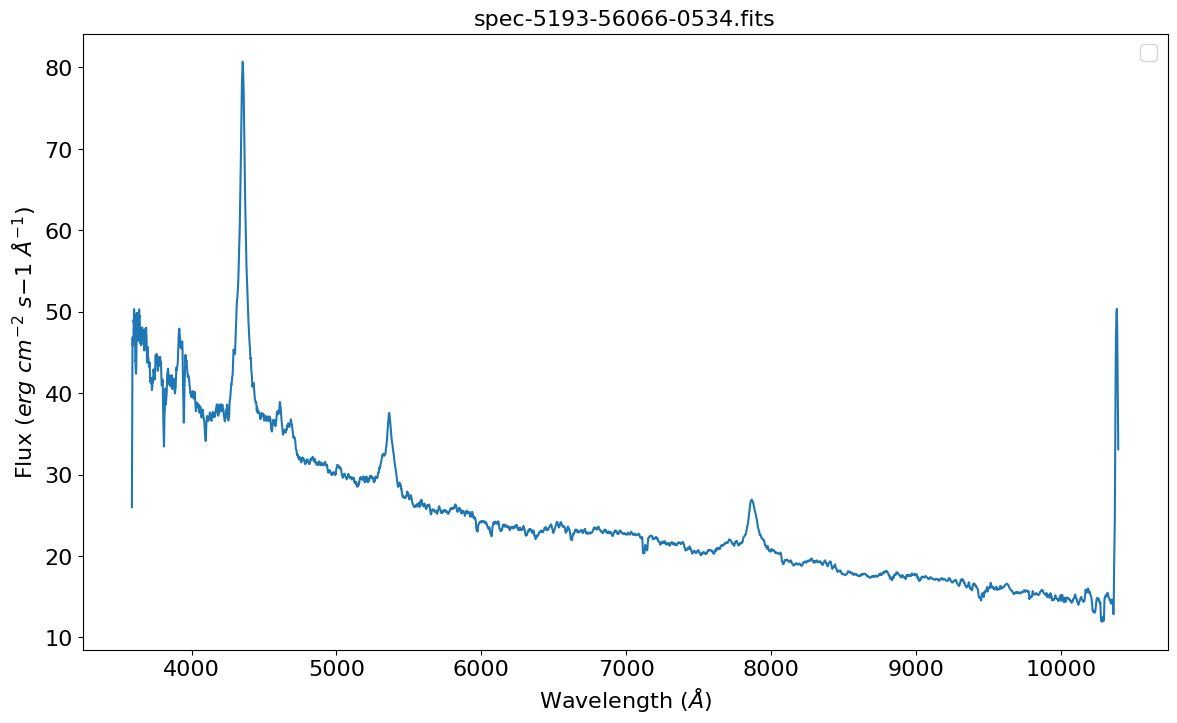

In [ ]:
spec1_bsmooth = box_smooth(spec, width=10)
plot_spectrum_before(filenames[file_index], spec1_bsmooth.wavelength, spec1_bsmooth.flux)

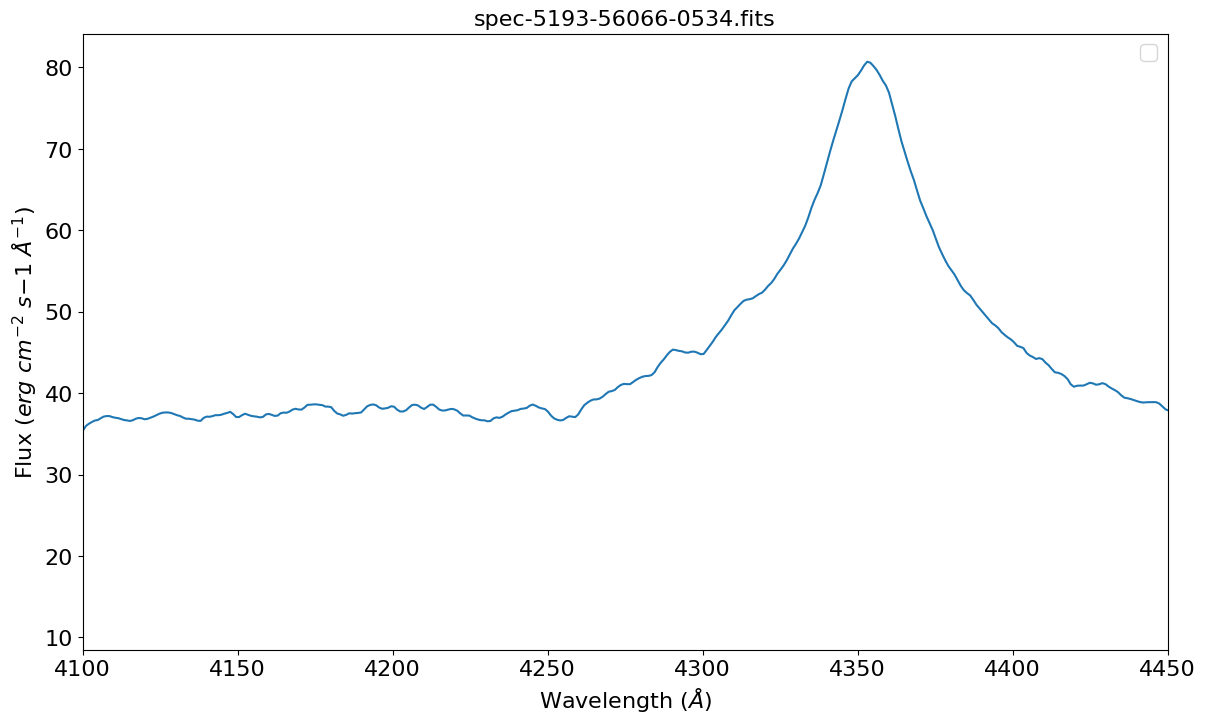

In [ ]:
plot_spectrum_after(filenames[file_index], spec1_bsmooth.wavelength, spec1_bsmooth.flux,  4100, 4450)

In [ ]:
#estimating the line parameters
gauss_paramters(spec1_bsmooth, 7780, 8000)

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
       amplitude           mean            stddev     
           Jy            Angstrom         Angstrom    
    ---------------- --------------- -----------------
    26.9317684173584 7887.2470703125 61.50954818725586


Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude             mean             stddev     
            Jy              Angstrom          Angstrom    
    ------------------ ----------------- -----------------
    10.238952821664364 7876.264881478634 88.90808343474114


'\n"1) C IV = 1548.2\n2) C III [1908.7]\n3) Mg II [2802.7]"\n'

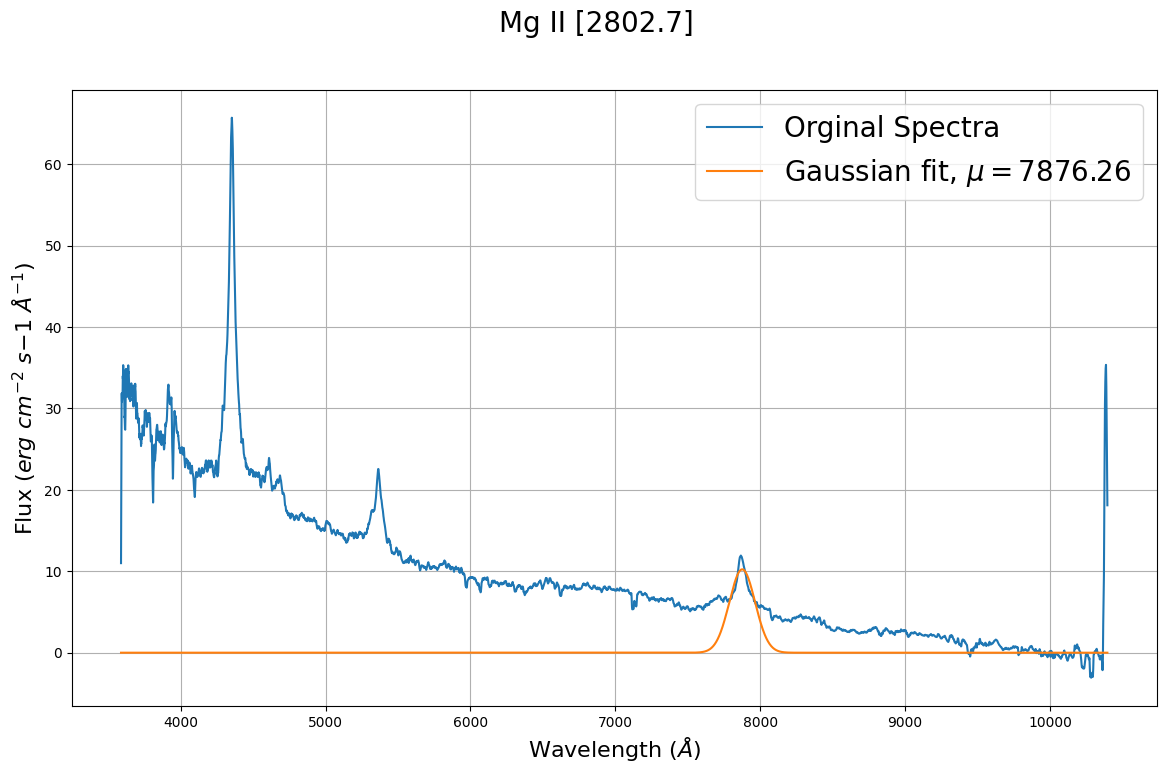

In [ ]:
'''
For copy- paste purpose (nothing special)

The observed peaks in the spectrum (in armstrong) for C III [1908.7] is = 5364.467800671749
The observed peaks in the spectrum (in armstrong) for C IV [1548.2] is = 4351.27
The observed peaks in the spectrum (in armstrong) for Mg II [2802.7] is = 7877.085924945098
The observed peaks in the spectrum (in armstrong) for Hα [6562.7] is = 18444.69682792921
The observed peaks in the spectrum (in armstrong) for Hβ [4861.3] is = 13662.852894328898
The observed peaks in the spectrum (in armstrong) for Hγ [4340.4] is = 12198.845309391552
The observed peaks in the spectrum (in armstrong) for Hδ [4101.7] is = 11527.970649140938
The observed peaks in the spectrum (in armstrong) for [O III] [4958.9] is = 13937.161092236145
The observed peaks in the spectrum (in armstrong) for [O III] [5006.8] is = 14071.78570985661
The observed peaks in the spectrum (in armstrong) for [N II] [6544.2] is = 18392.701933858676
The observed peaks in the spectrum (in armstrong) for [N II] [6583.5] is = 18503.15595207338
The observed peaks in the spectrum (in armstrong) for [S II] [6715.8] is = 18874.98970804806
The observed peaks in the spectrum (in armstrong) for [S II] [6732.8] is = 18922.768799896658
The observed peaks in the spectrum (in armstrong) for O II [3727.3] is = 10475.706414545926
'''

#subtracting a constant value from the flux
value = 15*u.Jy

#make a new spectrum1D object for fitting
final_spectrum = Spectrum1D(flux=spec1_bsmooth.flux - value, spectral_axis=spec1_bsmooth.wavelength)

fit_spec(spectra = final_spectrum, low= 7780, high= 8000, amp = 10, mu = 7887, sigma = 10, mode = "2window", reference_line = "Mg II [2802.7]")

"""
"1) C IV = 1548.2
2) C III [1908.7]
3) Mg II [2802.7]"
"""


In [ ]:
# From the manual, THE REST FRAME WAVELENGTH OF THE REFERENCE LINE
lambda_init = 1548.2 #armstrong

#mean lambda determined using the reference line given in the manual
# change mean_lambda for every fits file
obs_mean_lambda = 4351.27 #armstrong
c =  299792458 #m/s

# velocity calculated from the reference line given in the lab manual
#change vel for every fits file
vel = ((obs_mean_lambda- lambda_init)/lambda_init)*c   #m/s
print("Velocity (m/s):", '{:.3e}'.format(vel))

Velocity (m/s): 5.428e+08


In [ ]:
'''
THEORY:

You may consider using a Gaussian fit to the spectral lines
to obtain the peak wavelength of the desired line. The rest wavelength of a reference line
is provided, which can be used to determine the wavelength-shift ∆λ. Once ∆λ for a given
spectral line is known, one can determine the velocity of the object. Use this value of
velocity along with the given reference wavelengths of some known spectral lines
(provided below) to assign at least two more spectral lines and their shift in wavelengths.
The velocity of the object can be determined using these lines as well. Now one can
determine the average velocity of the galaxy along with an error estimate.
'''

#===============================================================================

# For calculating other peaks and their corresponding peaks..
lambda_0 = np.array([1908.7, 1548.2, 2802.7, 6562.7, 4861.3, 4340.4, 4101.7, 4958.9, 5006.8, 6544.2, 6583.5, 6715.8, 6732.8, 3727.3]) # Armstrongs
ref_line_0 = ['C III', 'C IV', 'Mg II', 'Hα', 'Hβ', 'Hγ', 'Hδ', '[O III]', '[O III]', '[N II]','[N II]', '[S II]', '[S II]', 'O II']


'''
Use this value of velocity along with the given reference wavelengths of 
some known spectral lines (provided below) to assign at least two more 
spectral lines and their shift in wavelengths.
'''

#finding delta_lambda using doppler shift formula
delta_lambda = (vel/c)*lambda_0

# adding the difference to in wavelength due to redshift the rest frame wavelengths
lambda_1 = delta_lambda + lambda_0

# showing the redshifted wavelengths
for i in range(len(lambda_0)):
  print("The observed peaks in the spectrum (in armstrong) for {} [{}] is = {}".format(ref_line_0[i], lambda_0[i], lambda_1[i]))


The observed peaks in the spectrum (in armstrong) for C III [1908.7] is = 5364.467800671749
The observed peaks in the spectrum (in armstrong) for C IV [1548.2] is = 4351.27
The observed peaks in the spectrum (in armstrong) for Mg II [2802.7] is = 7877.085924945098
The observed peaks in the spectrum (in armstrong) for Hα [6562.7] is = 18444.69682792921
The observed peaks in the spectrum (in armstrong) for Hβ [4861.3] is = 13662.852894328898
The observed peaks in the spectrum (in armstrong) for Hγ [4340.4] is = 12198.845309391552
The observed peaks in the spectrum (in armstrong) for Hδ [4101.7] is = 11527.970649140938
The observed peaks in the spectrum (in armstrong) for [O III] [4958.9] is = 13937.161092236145
The observed peaks in the spectrum (in armstrong) for [O III] [5006.8] is = 14071.78570985661
The observed peaks in the spectrum (in armstrong) for [N II] [6544.2] is = 18392.701933858676
The observed peaks in the spectrum (in armstrong) for [N II] [6583.5] is = 18503.15595207338


In [ ]:
# Calculating v1,v2,v3 for the observation table

#references line from the observation table
lambda_00 = np.array([6567.7, 6562.7, 6562.7, 1548.2, 2802.7, 6562.7, 6562.7, 1548.2])
lambda_01 = np.array([6544.2, 5006.8, 5006.8, 2802.7, 1908.7, 6715.8, 6515.8, 1908.7])
lambda_02 = np.array([4861.3, 4861.3, 3727.3, 1908.7, 1548.2, 5006.8, 4861.3, 2802.7])

#delta lambda from the observation table
delta_lambda_00 = np.array([247.03, 18.75, 260.01, 2677.59, 4202.9, 109.18, 83.7, 2803.07])
delta_lambda_01 = np.array([198.93, 13.48, 181.63, 4846.15, 3838.31, 116.22, 86.17, 3437.31])
delta_lambda_02 = np.array([209.97, 13.45, 135.26, 3288.53, 2325.34, 81.65, 62.01, 5073.56])

#Calculating v1,v2,v3 in km/s
v00 = ((delta_lambda_00/lambda_00)*c)*0.001
v01 = ((delta_lambda_01/lambda_01)*c)*0.001
v02 = ((delta_lambda_02/lambda_02)*c)*0.001

np.set_printoptions(formatter={'float_kind':'{:.3e}'.format})

print(v00,'\n',v01,'\n', v02)

[1.128e+04 8.565e+02 1.188e+04 5.185e+05 4.496e+05 4.987e+03 3.824e+03
 5.428e+05] 
 [9.113e+03 8.071e+02 1.088e+04 5.184e+05 6.029e+05 5.188e+03 3.965e+03
 5.399e+05] 
 [1.295e+04 8.295e+02 1.088e+04 5.165e+05 4.503e+05 4.889e+03 3.824e+03
 5.427e+05]


In [ ]:
from matplotlib import rc


# Matplotlib settings

linewidths = 2
axislinewidths = 3
lenticks = 6

plt.rcParams['figure.figsize'] = (12.0, 8.0)
plt.rcParams['lines.markersize'] = 10
rc('font', family='sans-serif', size=18)
rc('xtick.major', size=lenticks)
rc('xtick.minor', size=lenticks * 2 / 3)
rc('ytick.major', size=lenticks)
rc('ytick.minor', size=lenticks * 2 / 3)
rc('lines', linewidth=linewidths)
rc('axes', linewidth=axislinewidths)

Age of the Universe (1/H): 1.3797e+10 years


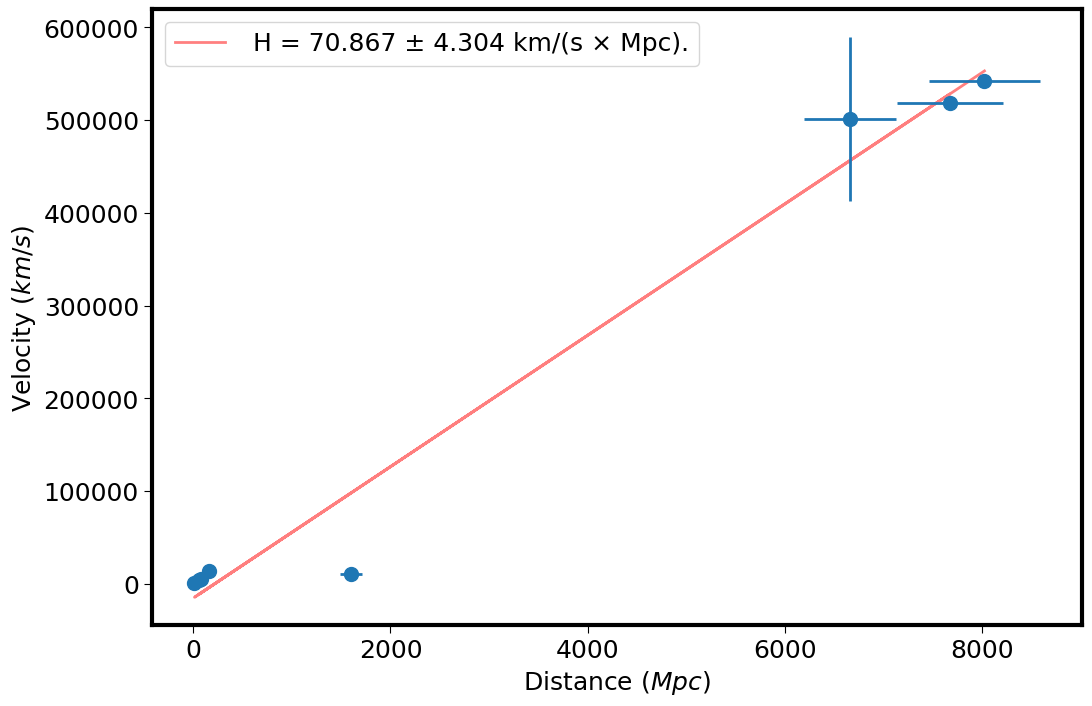

In [ ]:
# For calculating Hubble's constant and Age of the Universe

avg_v = np.array([1.11E+04,
8.31E+02,
1.35E+04,
5.18E+05,
5.01E+05,
5.02E+03,
3.87E+03,
5.42E+05])

v_err = np.array([1923.85715,
24.73566925,
4572.614132,
1126.942767,
88306.41728,
152.4281251,
81.40638796,
1646.207763])


distance = np.array([1597.44, 13.35, 164.54, 7668.09, 6656.11, 75.39, 59.32, 8021.11])
distance_err = np.array([111.82, 0.95, 11.52, 536.77, 465.93, 5.29, 4.16, 561.48])

#fitting a straight lline
from scipy import stats
res1 = stats.linregress(distance, avg_v)
plt.plot(distance, res1.intercept + res1.slope*distance, 'red', label=' H = {} ± {} km/(s × Mpc).'.format(round(res1.slope,3), round(res1.stderr,3)), alpha = 0.5)

plt.errorbar(distance, avg_v, xerr = distance_err, yerr = v_err, fmt="o", markersize='10')
#plt.scatter(distance, avg_v)

#plt.yscale('log')
#plt.xscale('log')

plt.xlabel("Distance($Mpc$)")
plt.xlabel("Distance ($Mpc$)")
plt.ylabel("Velocity ($km/s$)")
plt.legend(loc = 'upper left')


#hubbles const
h = round(res1.slope,3)

#calculating age of the universe
universe_age = 1/(h*3.2408e-20*3600*24*365.26) # Unit is in seconds; cz 1km/1Mpc = 1km /206265e6 AU 
#universe_age = universe_age/3600*24*365.26 #converting seconds into years

#universe_age_err = (round(res1.stderr,3)*3.2408e-20*3600*24*365.26)
#print("Age of the Universe (1/H): '{:.4e}' ± '{:.4e}' years".format(universe_age, universe_age_err))
print("Age of the Universe (1/H): {:.4e} years".format(universe_age))